In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ball_pos = pd.read_pickle("../data/feature/cfbe2e94_1/ball.pickle")
ball_movement = pd.read_pickle("../data/feature/cfbe2e94_1/ball_movement.pickle")

In [4]:
ball_pos.head()

,frame,conf_ball,x_ball,y_ball,isnull
0,0,0.276855,0.449479,0.774074,0
1,1,0.293457,0.449479,0.774074,0
2,2,0.294189,0.449479,0.774074,0
3,3,0.261475,0.449479,0.774074,0
4,4,0.258301,0.449479,0.774074,0


In [5]:
ball_movement.head()

,x_ball_t1,y_ball_t1,x_ball_t4,y_ball_t4,x_ball_t-1,y_ball_t-1,x_ball_t-4,y_ball_t-4
0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
3,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
v1 = np.sqrt(((ball_pos[["x_ball", "y_ball"]] - np.array([0.5, 0.5])) ** 2).sum(axis=1).to_numpy())
v2 = np.sqrt(((ball_movement[["x_ball_t1", "y_ball_t1"]] - np.array([0.5, 0.5])) ** 2).sum(axis=1).to_numpy())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

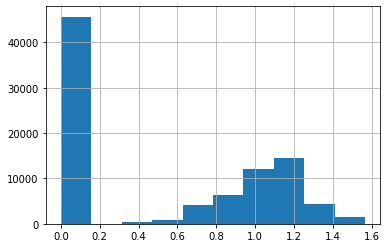

In [42]:
pd.Series().dropna().hist()

In [63]:
import xgboost as xgb
import matplotlib.pyplot as plt

In [64]:
bst = xgb.XGBClassifier()
bst.load_model("../data/model/xgb_1fold.json")

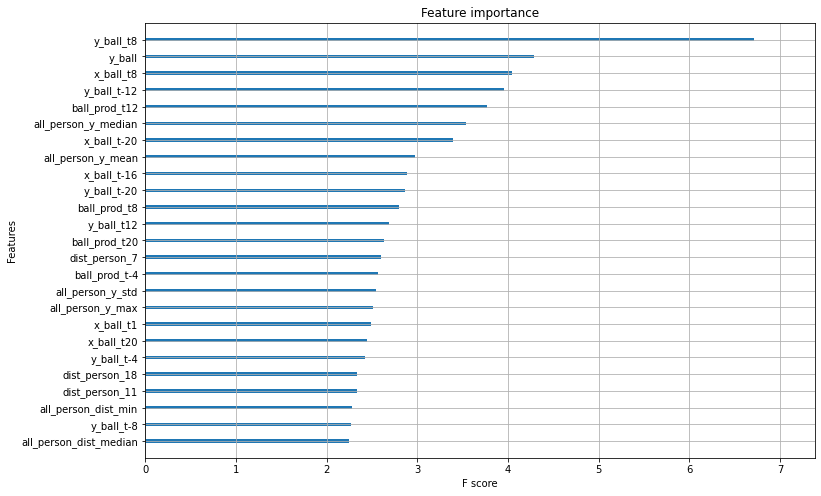

In [65]:
j_, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(
    bst,
    ax=ax,
    importance_type='gain',
    show_values=False,
    max_num_features=25
)
plt.show()

In [25]:
import glob
import os
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm


def calc_distance(a: Tuple, b: Tuple):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def person(obj_pos, ball_pos):
    """
    Person feature is x, y, conf, distance (from ball position).
    """

    person_pos = obj_pos.query("obj_name=='person'")[["frame", "x", "y", "conf"]]
    person_pos = person_pos[person_pos["frame"].isin(ball_pos.index)]

    ball_pos = ball_pos.loc[person_pos["frame"], ["x_ball", "y_ball"]].to_numpy()

    person_pos["dist"] = calc_distance(
        (person_pos["x"], person_pos["y"]), (ball_pos[:, 0], ball_pos[:, 1])
    )
    person_pos["rank"] = person_pos.groupby("frame")["dist"].rank().astype(int)
    person_pos = person_pos.query("rank < 24")
    person_pos = person_pos.assign(obj_name="person_" + person_pos["rank"].astype(str))
    person_pos = person_pos.pivot_table(
        index=["frame"],
        columns=["obj_name"],
        values=["x", "y"],  # type: ignore
    ).reset_index()
    person_pos.columns = [c[0] if "" in c else "_".join(c) for c in person_pos.columns]

    # NOTE: Add stats features.
    for xy in ["x", "y"]:
        person_pos = person_pos.assign(
            **{
                f"all_person_{xy}_{func}": person_pos[
                    [f"{xy}_person_{i}" for i in range(1, 23)]
                ].agg(func, axis=1)
                for func in ["mean", "min", "max", "std", "median"]
            }
        )

    # person_pos.drop(
    #     [f"{xy}_person_{i}" for i in range(1, 24) for xy in ["x", "y"]],
    #     axis=1,
    #     inplace=True,
    # )
    return person_pos

In [26]:
obj_pos = pd.read_csv("../data/feature/1606b0e6_0/detect.csv")
ball_pos = pd.read_pickle("../data/feature/1606b0e6_0/ball.pickle")

In [27]:
out = person(obj_pos, ball_pos)

In [28]:
out.head()

,frame,x_person_1,x_person_10,x_person_11,x_person_12,x_person_13,x_person_14,x_person_15,x_person_16,x_person_17,...,all_person_x_mean,all_person_x_min,all_person_x_max,all_person_x_std,all_person_x_median,all_person_y_mean,all_person_y_min,all_person_y_max,all_person_y_std,all_person_y_median
0,0,0.383594,0.700260,0.686979,0.730729,NaN,NaN,NaN,NaN,NaN,...,0.456858,0.147396,0.730729,0.185891,0.405990,0.868981,0.688889,0.969444,0.109185,0.910648
1,1,0.383594,0.700781,0.731250,NaN,NaN,NaN,NaN,NaN,NaN,...,0.488163,0.147135,0.731250,0.177423,0.538802,0.852904,0.688889,0.963889,0.110370,0.894444
2,2,0.312240,0.700781,0.685938,0.730729,NaN,NaN,NaN,NaN,NaN,...,0.477995,0.146615,0.730729,0.181827,0.475130,0.841281,0.614352,0.969444,0.131615,0.910185
3,3,0.383594,0.685938,0.731250,NaN,NaN,NaN,NaN,NaN,NaN,...,0.492945,0.145052,0.731250,0.182973,0.538542,0.861785,0.688426,0.969444,0.115935,0.926389
4,4,0.383594,0.559635,0.701042,0.685938,0.73125,NaN,NaN,NaN,NaN,...,0.491967,0.144792,0.731250,0.177186,0.538542,0.860897,0.688889,0.969444,0.105589,0.893981


In [35]:
out[[f"y_person_{i}" for i in range(1, 24)]].isnull().sum(axis=1)

0        11
1        12
2        11
3        12
4        10
         ..
85909     0
85910     0
85911     0
85912     0
85913     0
Length: 85914, dtype: int64

In [46]:
person_pos = pd.read_pickle("../data/feature/1606b0e6_0/person.pickle")

In [47]:
person_pos.head()

,frame,dist_person_1,dist_person_10,dist_person_11,dist_person_12,dist_person_13,dist_person_14,dist_person_15,dist_person_16,dist_person_17,...,all_person_y_min,all_person_y_max,all_person_y_std,all_person_y_median,all_person_dist_mean,all_person_dist_min,all_person_dist_max,all_person_dist_std,all_person_dist_median,person_null_cnt
0,0,0.788487,1.161645,1.188176,1.209565,NaN,NaN,NaN,NaN,NaN,...,0.688889,0.969444,0.109185,0.910648,0.992441,0.788487,1.209565,0.153195,0.946819,11
1,1,0.788487,1.161959,1.209879,NaN,NaN,NaN,NaN,NaN,NaN,...,0.688889,0.963889,0.110370,0.894444,0.992855,0.788487,1.209879,0.147128,0.976966,12
2,2,0.689146,1.161221,1.187574,1.209565,NaN,NaN,NaN,NaN,NaN,...,0.614352,0.969444,0.131615,0.910185,0.976886,0.689146,1.209565,0.175120,0.963159,11
3,3,0.788083,1.187574,1.209879,NaN,NaN,NaN,NaN,NaN,NaN,...,0.688426,0.969444,0.115935,0.926389,1.002918,0.788083,1.209879,0.157239,0.976211,12
4,4,0.788487,1.101388,1.161378,1.187574,1.209879,NaN,NaN,NaN,NaN,...,0.688889,0.969444,0.105589,0.893981,1.001248,0.788487,1.209879,0.147009,0.976966,10


In [53]:
person_pos[[f"dist_person_{i}" for i in range(1, 24)]].iloc[3000]


dist_person_1     0.467952
dist_person_2     0.531745
dist_person_3     0.534141
dist_person_4     0.550218
dist_person_5     0.553853
dist_person_6     0.564504
dist_person_7     0.577253
dist_person_8     0.579961
dist_person_9     0.591951
dist_person_10    0.601198
dist_person_11    0.607813
dist_person_12    0.621996
dist_person_13    0.626087
dist_person_14    0.656841
dist_person_15    0.662209
dist_person_16    0.670747
dist_person_17    0.678982
dist_person_18    0.689100
dist_person_19    0.698737
dist_person_20    0.702667
dist_person_21    0.707383
dist_person_22    0.730761
dist_person_23    0.944869
Name: 3000, dtype: float64

In [59]:
(person_pos[[f"dist_person_{i}" for i in range(1, 24)]] < 0.01).sum(axis=1).value_counts()

0    85709
1      205
dtype: int64